In [546]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import neighbors,linear_model
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import SMOTE
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [320]:
train = pd.read_csv("train.csv")
train.tail()

,Unnamed: 0,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
795,272,male,0,standard,completed,74,71,65
796,853,male,2,standard,completed,72,72,72
797,894,male,3,standard,none,86,77,78
798,179,male,0,standard,completed,89,87,86
799,182,female,4,standard,none,84,95,89


In [321]:
test = pd.read_csv("test.csv")
test.head()

,Unnamed: 0,gender,lunch,test preparation course,math score,reading score,writing score
0,79,male,standard,none,54,43,45
1,277,female,standard,none,72,77,77
2,855,female,standard,none,87,97,100
3,922,male,standard,none,55,55,55
4,332,male,standard,none,56,54,43


In [322]:
train = train.rename(columns={"Unnamed: 0": "id"})
test = test.rename(columns={"Unnamed: 0": "id"})

In [323]:
for i in train.columns[1:]:
    print(train[i].unique())

['female' 'male']
[1 4 2 0 3 5]
['standard' 'free/reduced']
['none' 'completed']
[ 62  79  77  45  82  32  53  57  67  74  63  49  89  66  78  72  76  97
 100  75  65  60  83  43  88  71  80  54  48  70  84  55  59  61  69  92
  56  68  81  85  41  87  47  58  28  39  95  38  51  40  98  73  94  29
  36  64  23  52  90  37  86  50  30  46  91  93  96  42  99  33  44  35
  26  25  34  31  13]
[ 76  57  86  46  83  41  70  47  65  71  73  37  84  64  78  66  80  88
  36 100  50  61  95  68  85  87  77  82  62  72  79  43  54  90  48  97
  93  58  60  55  59  53  74  52  81  75  49  44  32  56  63  42  94  92
  67  38  69  27  89  33  51  34  91  98  39  96  45  40  31  99  28  35
  29]
[ 67  58  84  49  85  39  65  42  54  70  66  41  81  74  73  68  88  87
  32  79  83  76 100  45  82  93  63  78  60  95  62  56  71  77  53  51
  36  97  59  57  47  50  80  72  64  89  31  48  52  86  61  69  90  92
  27  94  75  44  43  55  35  26  33  40  98  99  96  30  28  34  38  24
  91  46  37  2

In [324]:
n_duplicates = train.drop(labels=["id"], axis=1).duplicated().sum()
print(f"We seem to have {n_duplicates} duplicates in our database.")

We seem to have 2 duplicates in our database.


In [325]:
# Handling duplicates based on id
columns_to_consider = train.drop(labels=["id"], axis=1).columns
train = train.drop_duplicates(subset=columns_to_consider)
train.shape

(798, 8)

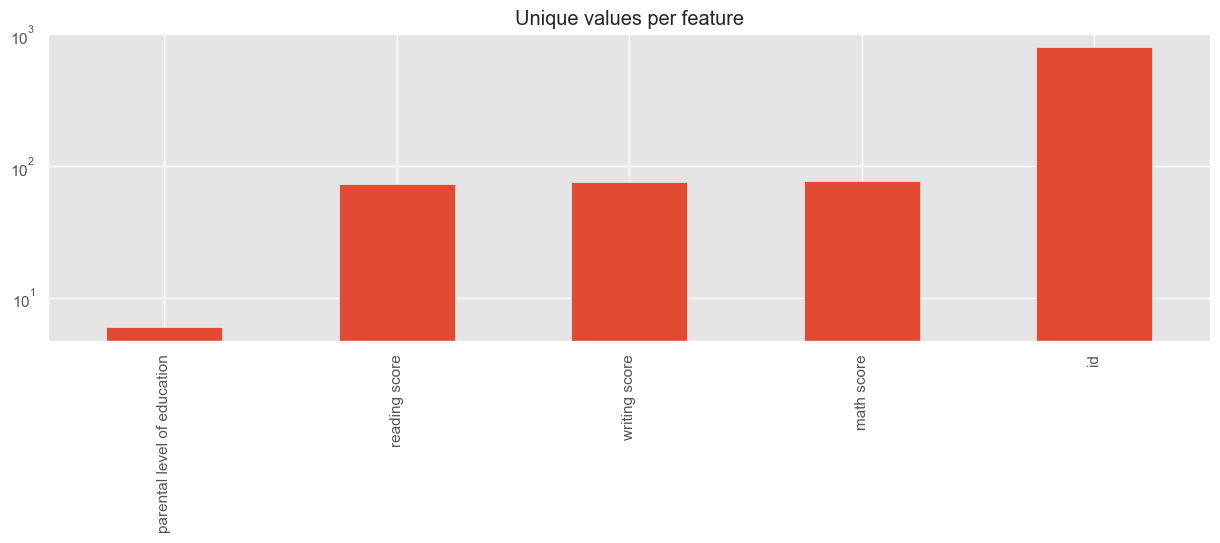

In [326]:
# For each numerical feature compute number of unique entries
unique_values = train.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

In [327]:
pd.DataFrame({"Null values": np.sum(train.isnull()), "Null percentages":\
              (np.sum(train.isnull())/len(train)) * 100})

,Null values,Null percentages
id,0,0.0
gender,0,0.0
parental level of education,0,0.0
lunch,0,0.0
test preparation course,0,0.0
math score,0,0.0
reading score,0,0.0
writing score,0,0.0


In [328]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,798.0,500.330827,289.026269,0.0,241.75,501.5,748.75,999.0
parental level of education,798.0,2.032581,1.521553,0.0,1.00,2.0,3.00,5.0
math score,798.0,66.503759,15.662833,13.0,56.00,66.5,77.00,100.0
reading score,798.0,69.077694,14.789751,27.0,60.00,70.0,79.00,100.0
writing score,798.0,67.776942,15.709897,23.0,58.00,68.0,79.00,100.0


In [329]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 799
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           798 non-null    int64 
 1   gender                       798 non-null    object
 2   parental level of education  798 non-null    int64 
 3   lunch                        798 non-null    object
 4   test preparation course      798 non-null    object
 5   math score                   798 non-null    int64 
 6   reading score                798 non-null    int64 
 7   writing score                798 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 56.1+ KB


In [330]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,200.0,497.860,289.623808,12.0,262.75,480.5,751.5,992.0
math score,200.0,65.685,14.130966,13.0,55.75,66.0,77.0,100.0
reading score,200.0,68.470,14.421825,36.0,59.00,68.5,79.0,100.0
writing score,200.0,67.355,15.070987,31.0,57.75,66.5,78.0,100.0


In [331]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       200 non-null    int64 
 1   gender                   200 non-null    object
 2   lunch                    200 non-null    object
 3   test preparation course  200 non-null    object
 4   math score               200 non-null    int64 
 5   reading score            200 non-null    int64 
 6   writing score            200 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 11.1+ KB


In [332]:
train_copy = train.copy()

In [333]:
train_copy["gender"] = train_copy["gender"].replace("female", 0)
train_copy["gender"] = train_copy["gender"].replace("male", 1)
train_copy["lunch"] = train_copy["lunch"].replace("free/reduced", 0)
train_copy["lunch"] = train_copy["lunch"].replace("standard", 1)
train_copy["test preparation course"] = train_copy["test preparation course"].replace("none", 0)
train_copy["test preparation course"] = train_copy["test preparation course"].replace("completed", 1)
train_copy.head()

,id,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,764,0,1,1,0,62,76,67
1,866,1,4,1,0,79,57,58
2,208,0,2,1,0,77,86,84
3,337,0,0,0,0,45,46,49
4,323,1,3,1,1,82,83,85


##### Exploratory Data Analysis

We have "gender", "lunch" and "test preparation course" as binary variables. 

In [334]:
def var_boxplot(var):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    train.boxplot(column=["math score"], by=var, ax=ax1)
    train.boxplot(column=["reading score"], by=var, ax=ax2)
    train.boxplot(column=["writing score"], by=var, ax=ax3)

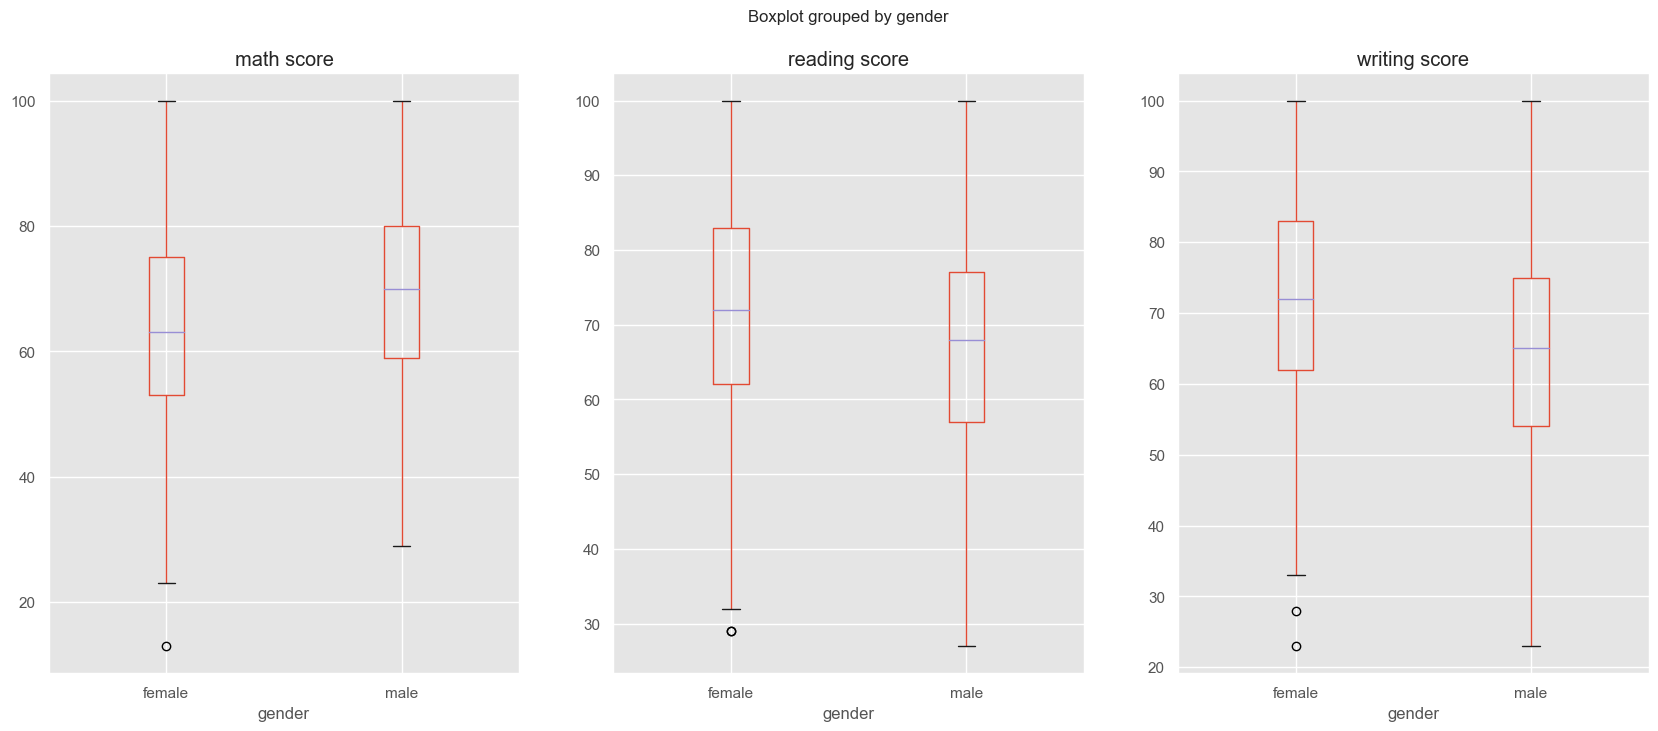

In [335]:
var_boxplot("gender")

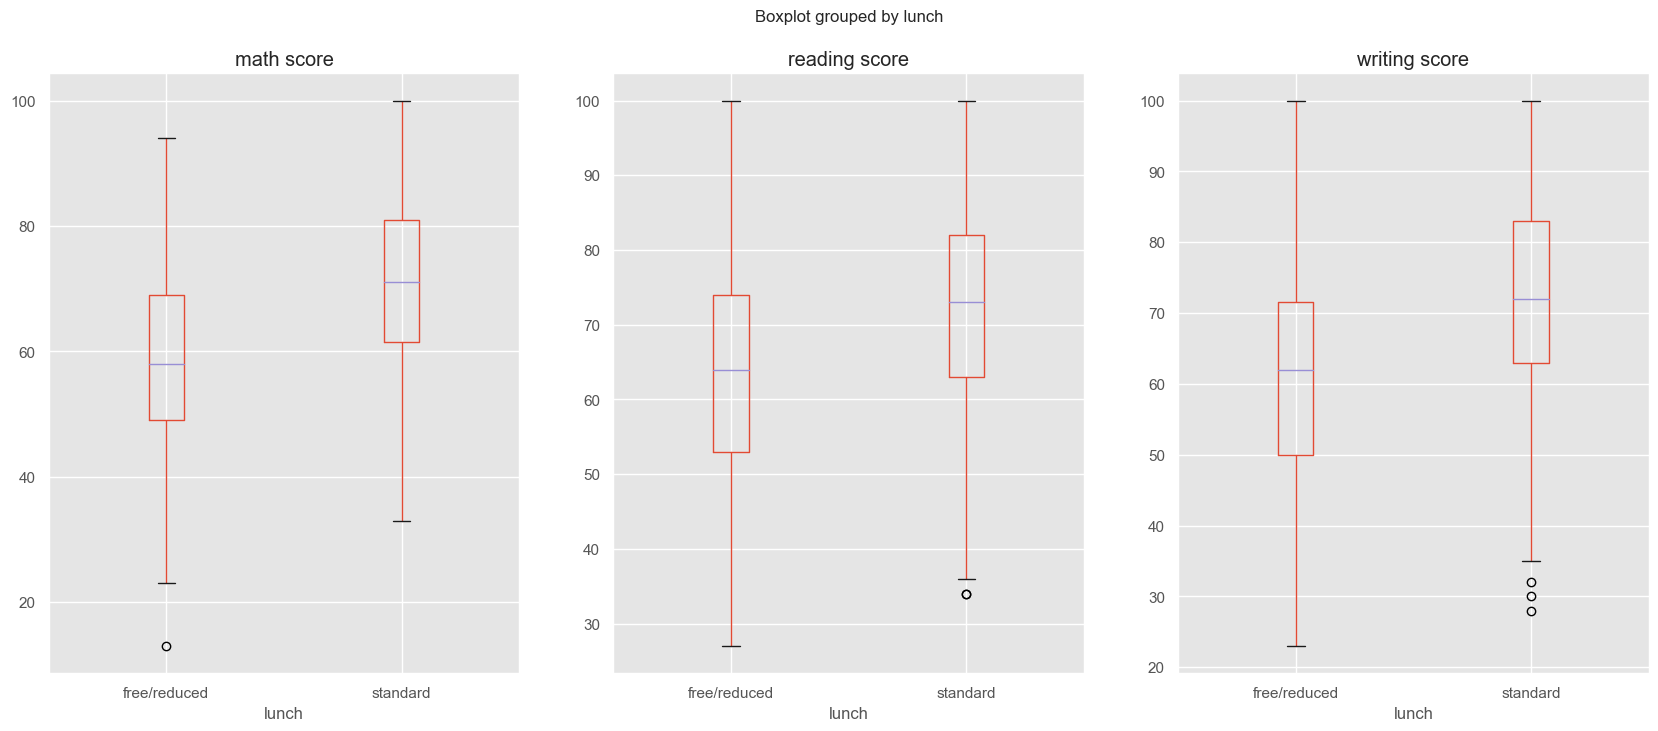

In [336]:
var_boxplot("lunch")

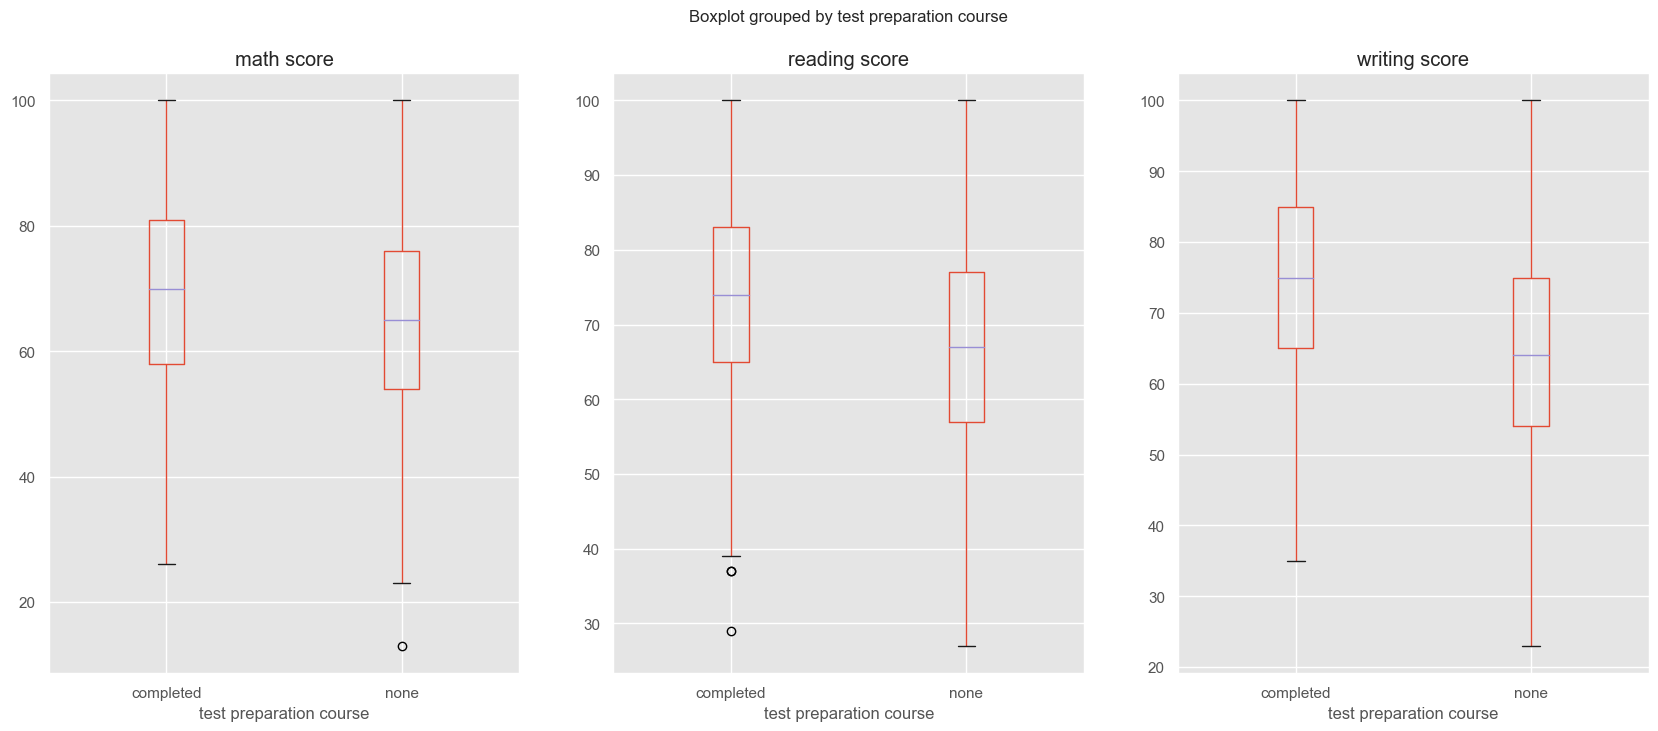

In [337]:
var_boxplot("test preparation course")

In [338]:
train["lunch"].unique()

array(['standard', 'free/reduced'], dtype=object)

In [339]:
def correlation_mat(x):
    methods = ["pearson", "spearman", "kendall"]
    palette = ["magma", "viridis", "cubehelix"]
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
    for i in range(3):
        sns.heatmap(x.corr(method=methods[i]), ax=axes[i], vmax=.8, square=True, annot=True, linewidths=.5, cmap=palette[i])
        axes[i].set_title(methods[i] + " correlation")

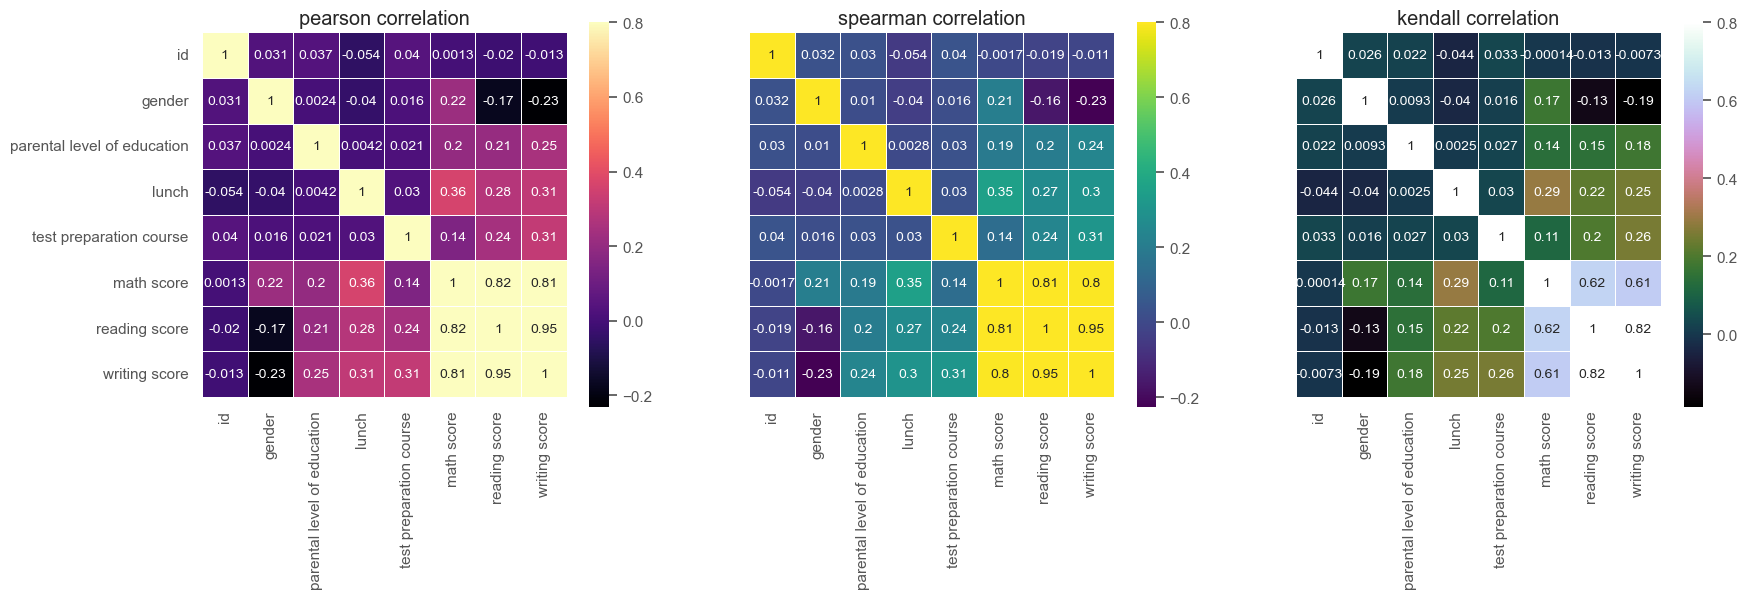

In [340]:
correlation_mat(train_copy)

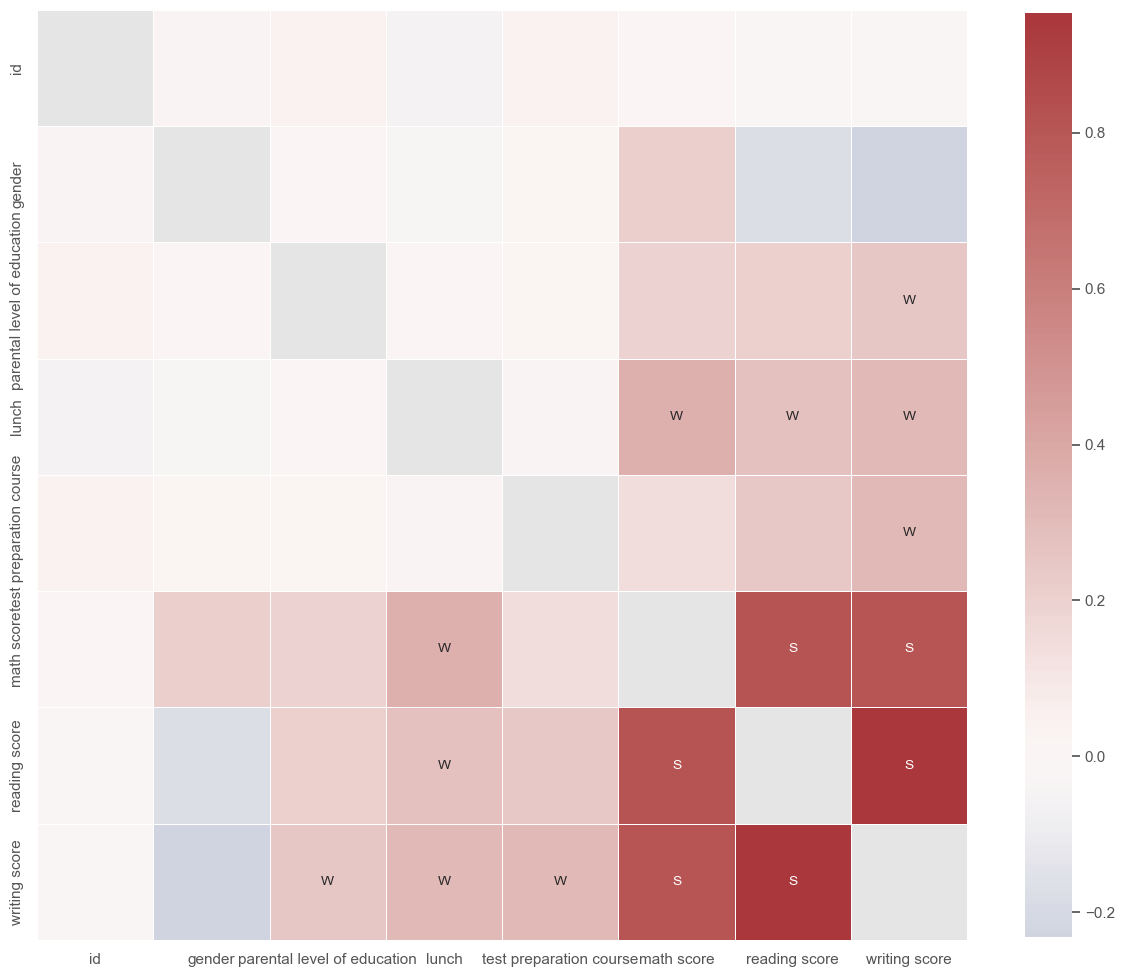

In [341]:
train_corr = train_copy.corr(method="pearson")
labels = np.where(np.abs(train_corr)>0.75, "S",
                  np.where(np.abs(train_corr)>0.5, "M",
                           np.where(np.abs(train_corr)>0.25, "W", "")))
plt.figure(figsize=(15, 15))
sns.heatmap(train_corr, mask=np.eye(len(train_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [342]:
lower_triangle_mask = np.tril(np.ones(train_corr.shape), k=-1).astype("bool")
df_corr_stacked = train_corr.where(lower_triangle_mask).stack().sort_values()
display(df_corr_stacked)

writing score                gender                        -0.231405
reading score                gender                        -0.172289
lunch                        id                            -0.053960
                             gender                        -0.039945
reading score                id                            -0.019970
writing score                id                            -0.012609
math score                   id                             0.001280
parental level of education  gender                         0.002439
lunch                        parental level of education    0.004248
test preparation course      gender                         0.016000
                             parental level of education    0.021028
                             lunch                          0.030471
gender                       id                             0.031381
parental level of education  id                             0.037411
test preparation course      id   

In [343]:
def var_boxplot_2(var):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("parental level of education")
    for i in range(2):
        for j in range(3):
            sns.boxplot(ax=axes[i, j], data=train, x="parental level of education", y=var)

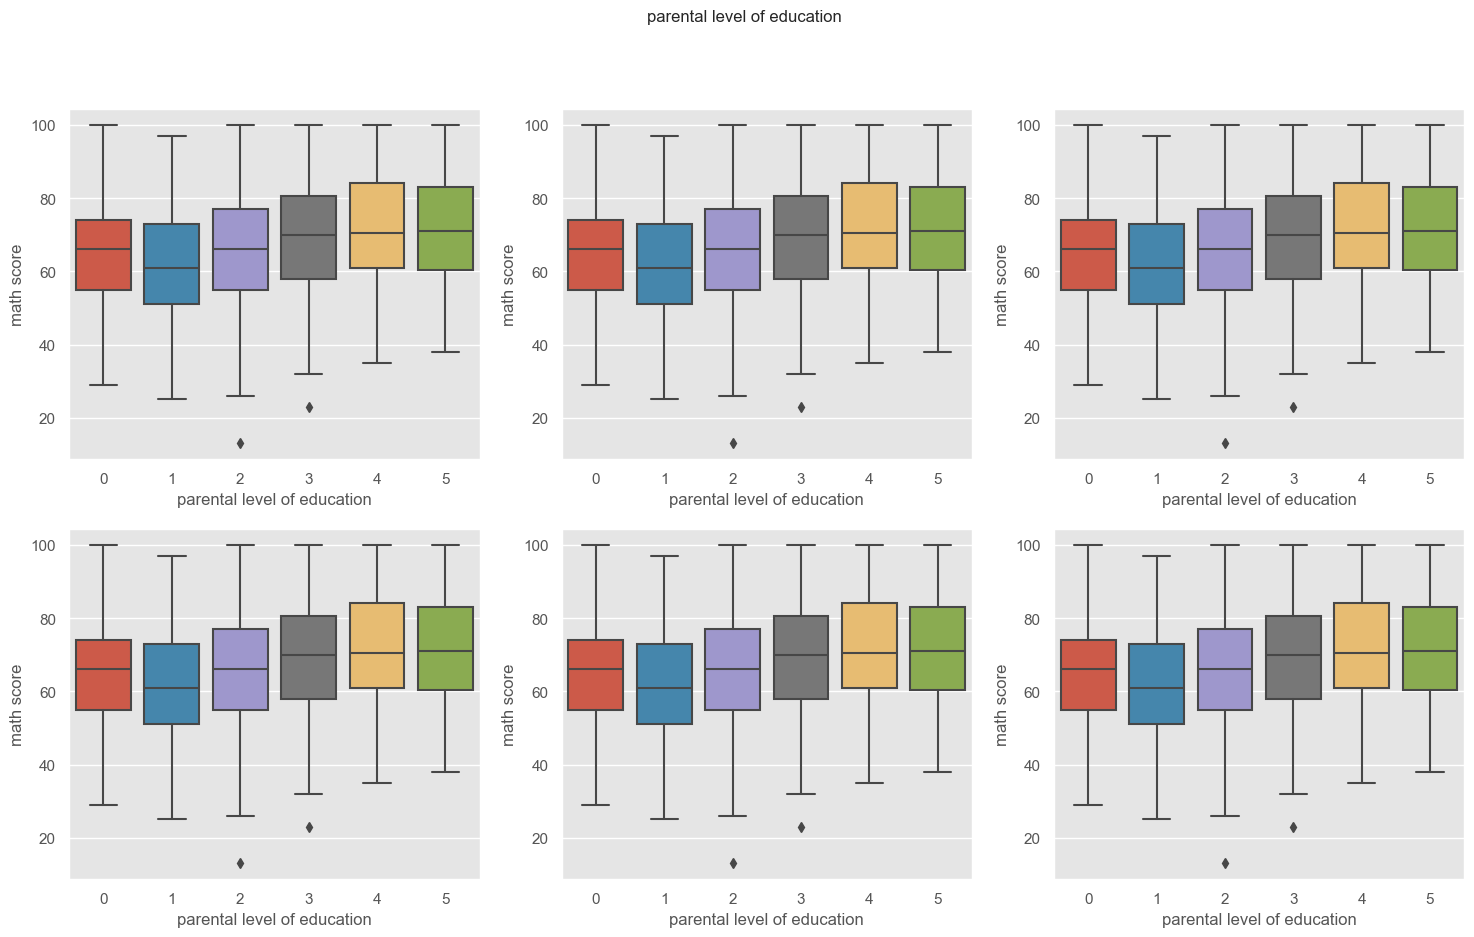

In [344]:
var_boxplot_2("math score")

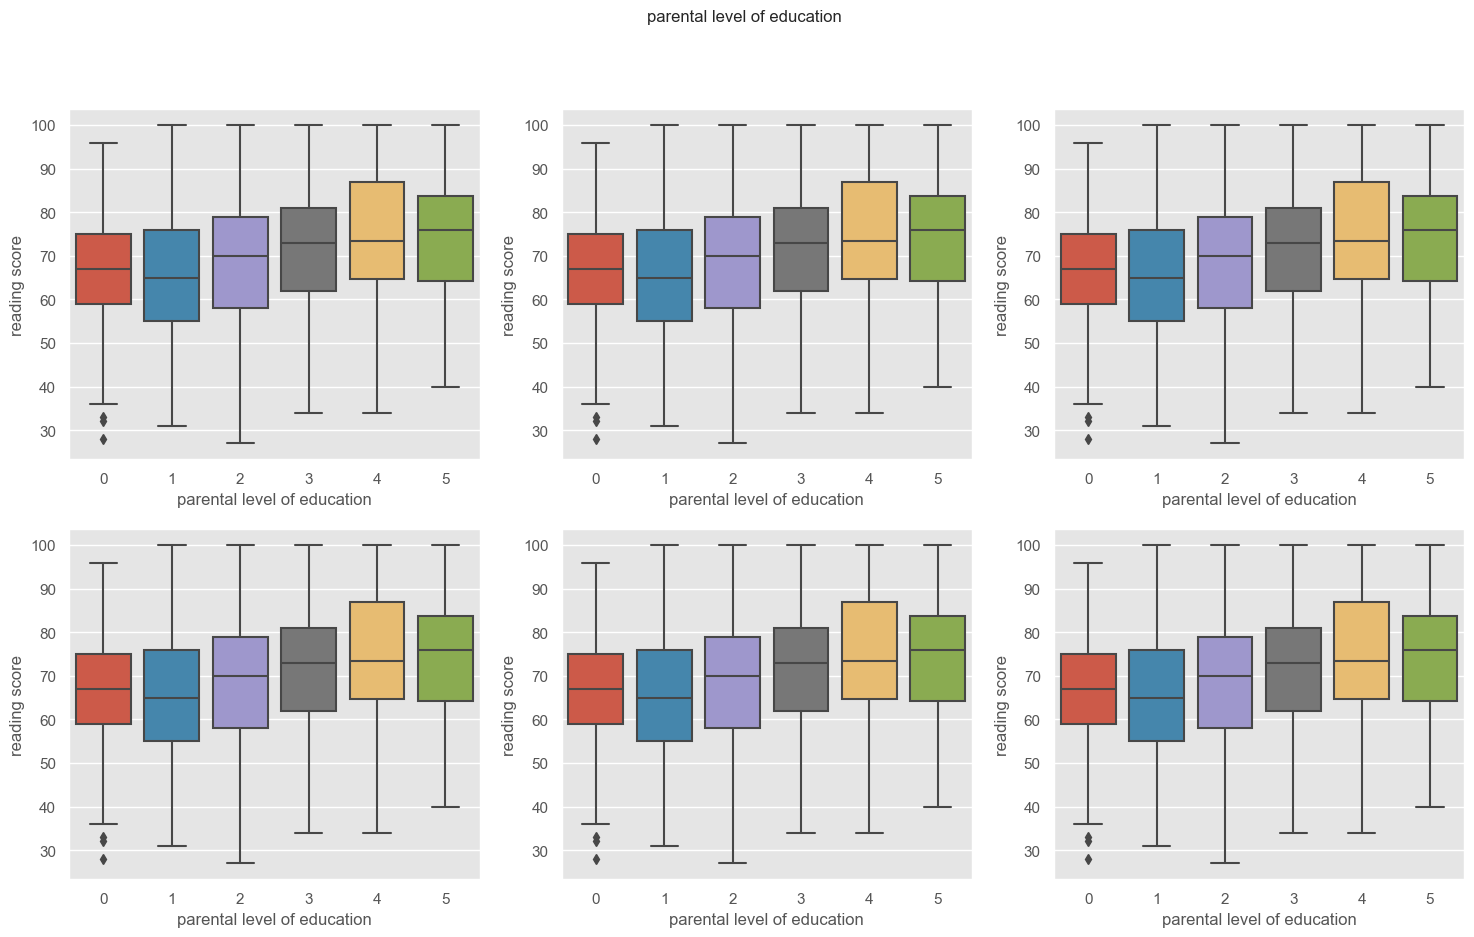

In [345]:
var_boxplot_2("reading score")

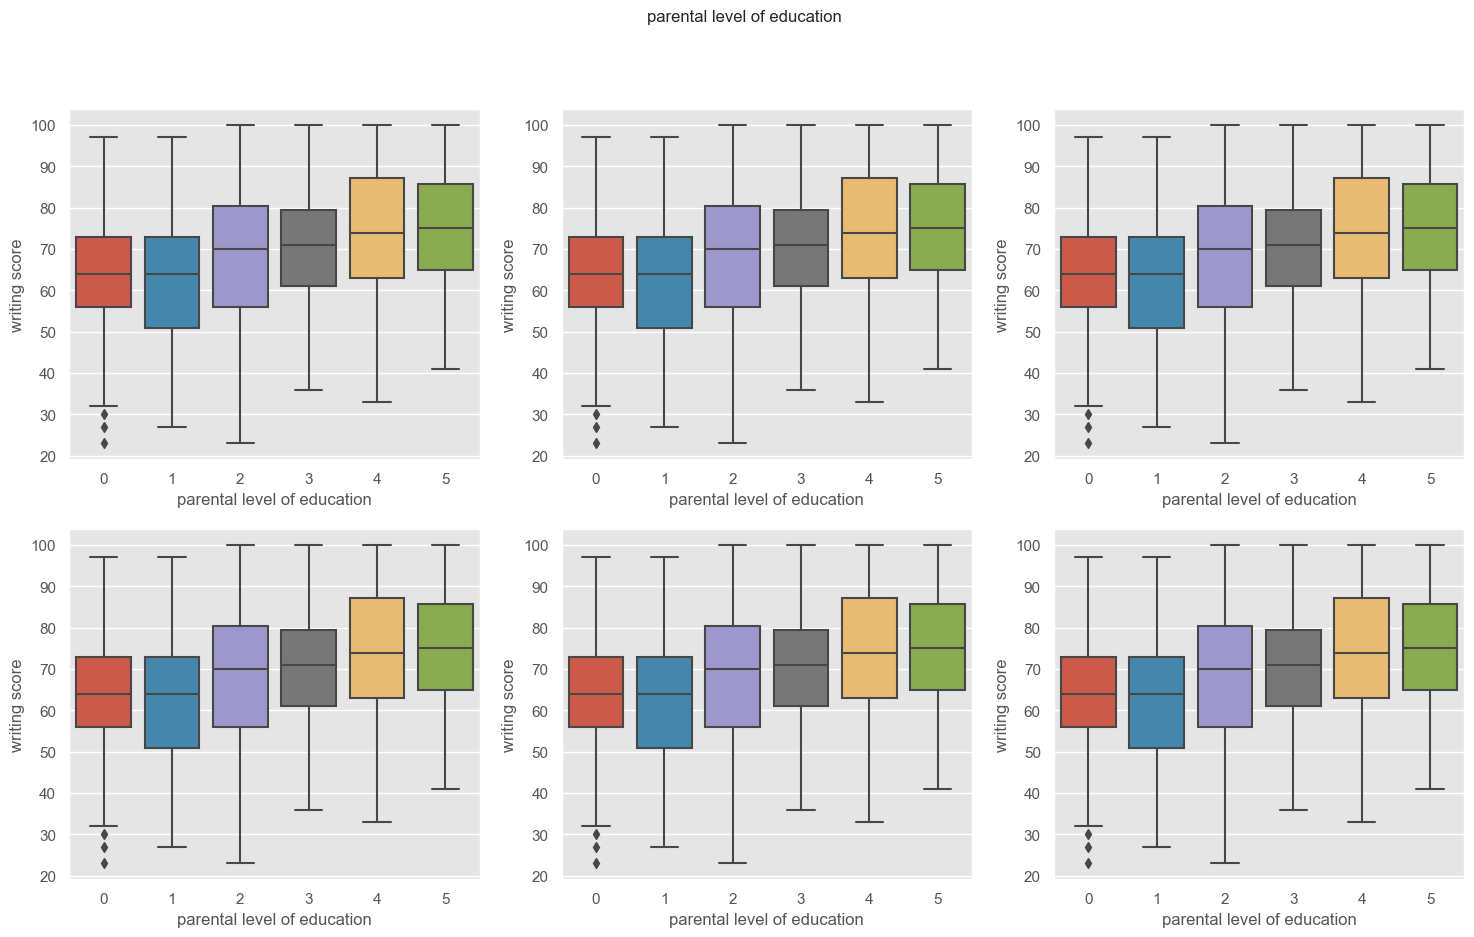

In [346]:
var_boxplot_2("writing score")

In [347]:
train.head()

,id,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,764,female,1,standard,none,62,76,67
1,866,male,4,standard,none,79,57,58
2,208,female,2,standard,none,77,86,84
3,337,female,0,free/reduced,none,45,46,49
4,323,male,3,standard,completed,82,83,85


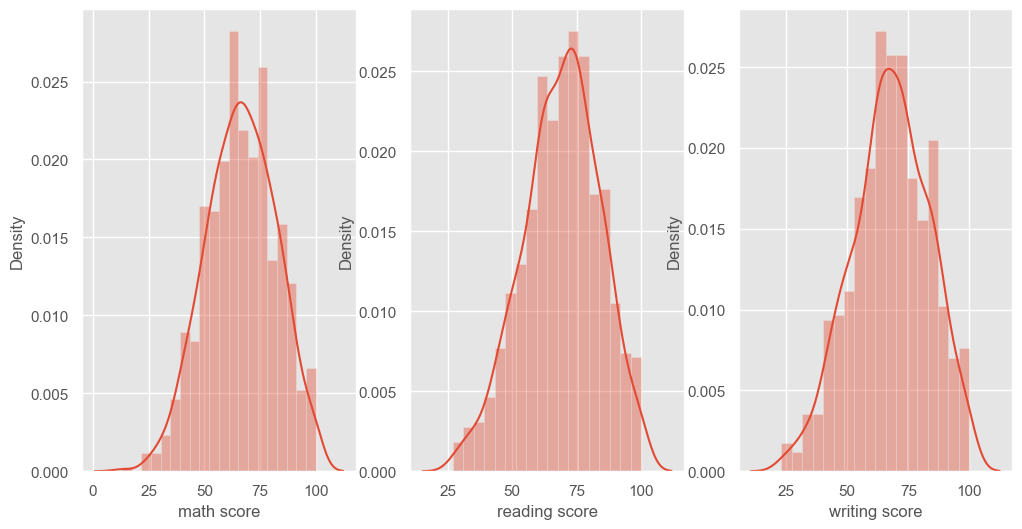

In [348]:
c = 0
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
for i in train.columns[-3:]:
    sns.distplot(train[i], ax=ax[c])
    c += 1

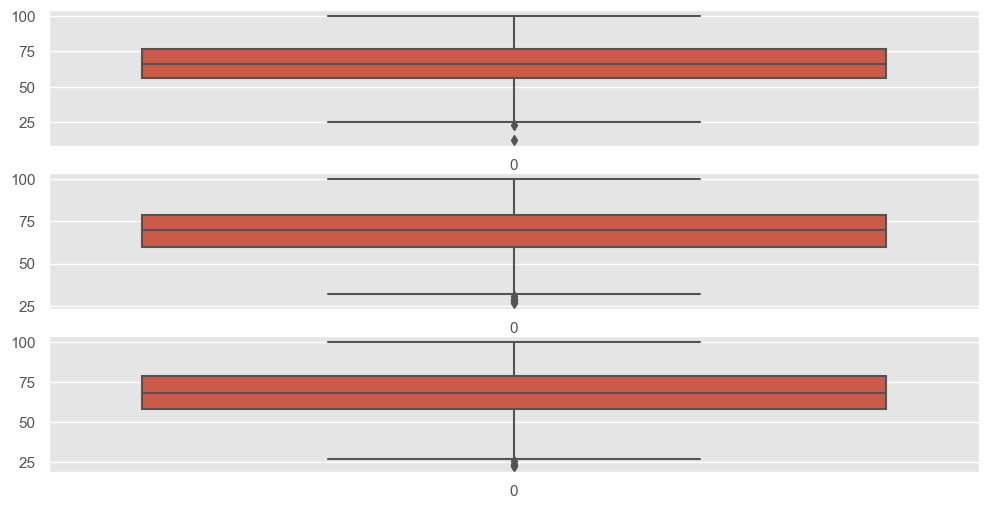

In [349]:
c = 0
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
for i in train.columns[-3:]:
    sns.boxplot(train[i], ax=ax[c])
    c += 1

In [350]:
binary_var = ["gender", "lunch", "test preparation course"]

In [351]:
def binary_comparison(df=train):
    c = 0
    fig, ax = plt.subplots(3, 1, figsize=(12, 18))
    for i in binary_var:
        sns.countplot(df[i], ax=ax[c])
        c += 1

binary_comparison()

<AxesSubplot:>

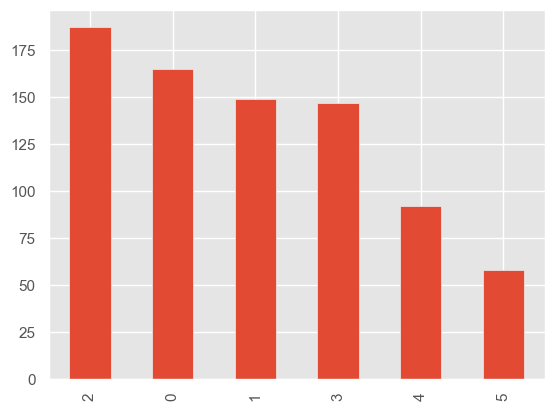

In [352]:
train["parental level of education"].value_counts().plot.bar()

In [353]:
train["mean_score"] = round(train[["math score", "reading score", "writing score"]].mean(axis=1), 2)
train.head()

,id,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score
0,764,female,1,standard,none,62,76,67,68.33
1,866,male,4,standard,none,79,57,58,64.67
2,208,female,2,standard,none,77,86,84,82.33
3,337,female,0,free/reduced,none,45,46,49,46.67
4,323,male,3,standard,completed,82,83,85,83.33


In [354]:
print(f"Skewness of ", train["mean_score"].skew())
print(f"Kurtosis of ", train["mean_score"].kurt())
print(f"Mean of ", train["mean_score"].mean())
print(f"Median of ", train["mean_score"].median())

Skewness of  -0.2136195169327114
Kurtosis of  -0.3404884492760014
Mean of  67.78609022556395
Median of  67.83500000000001


In [355]:
pd.DataFrame(train.groupby(["parental level of education"])["test preparation course"].value_counts())

test preparation course
parental level of education test preparation course                         
0                           none                                         118
                            completed                                     47
1                           none                                          98
                            completed                                     51
2                           none                                         116
                            completed                                     71
3                           none                                          90
                            completed                                     57
4                           none                                          60
                            completed                                     32
5                           none                                          43
                            completed                                     15

In [356]:
round(train.groupby(["gender","parental level of education"])[["math score", "reading score", "writing score", "mean_score" ]].mean(), 2)

math score  reading score  writing score  \
gender parental level of education                                             
female 0                                 61.39          69.23          68.30   
       1                                 57.25          66.55          65.49   
       2                                 62.74          72.54          72.95   
       3                                 66.00          73.75          73.64   
       4                                 67.47          76.84          77.67   
       5                                 70.24          78.15          79.15   
male   0                                 67.43          64.45          60.48   
       1                                 66.45          62.66          59.83   
       2                                 68.13          65.36          62.85   
       3                                 72.05          69.19          67.66   
       4                                 76.20          72.06          71.69   
       5                                 73.00          70.80          69.60   

                                    mean_score  
gender parental level of education              
female 0                                 66.31  
       1                                 63.10  
       2                                 69.41  
       3                                 71.13  
       4                                 73.99  
       5                                 75.85  
male   0                                 64.12  
       1                                 62.98  
       2                                 65.45  
       3                                 69.63  
       4                                 73.32  
       5                                 71.13

In [357]:
pd.DataFrame(train.groupby("gender").size())

,0
gender,
female,383
male,415


In [358]:
round(train.groupby("gender")["math score"].agg(
    mean="mean",
    median="median",
    standard_deviation="std"
), 2)

,mean,median,standard_deviation
gender,,,
female,62.99,63.0,15.46
male,69.75,70.0,15.15


In [359]:
# Do not use groupby with categorical variables, use pd.cut instead

groups = pd.cut(train["math score"], bins=3)
train.groupby(groups)["math score"].agg(count="count")

,count
math score,
"(12.913, 42.0]",53
"(42.0, 71.0]",440
"(71.0, 100.0]",305


<AxesSubplot:ylabel='Density'>

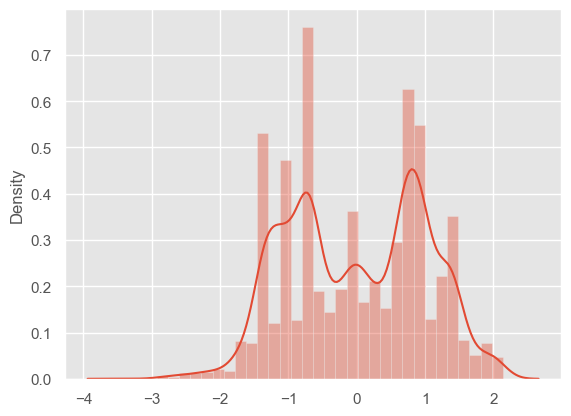

In [360]:
train_arr = train_copy.values
train_arr = np.asarray(train_arr)

# Finding normalised array of X_Train
x_std=StandardScaler().fit_transform(train_arr)
sns.distplot(x_std)

Text(0, 0.5, 'Cumulative explained variance')

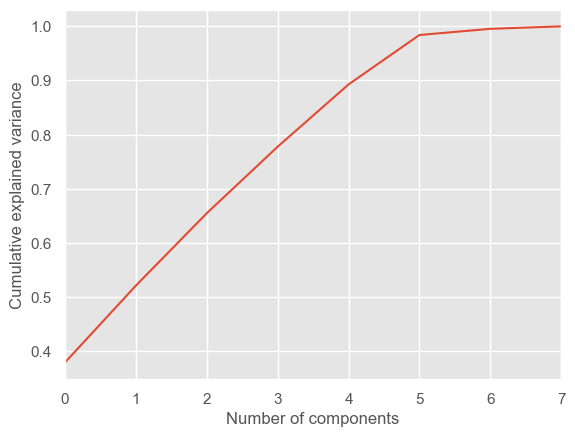

In [361]:
pca = PCA().fit(x_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 7, 1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

5 Components explain almost 100% of the variance.

TypeError: kdeplot() takes from 0 to 1 positional arguments but 2 were given

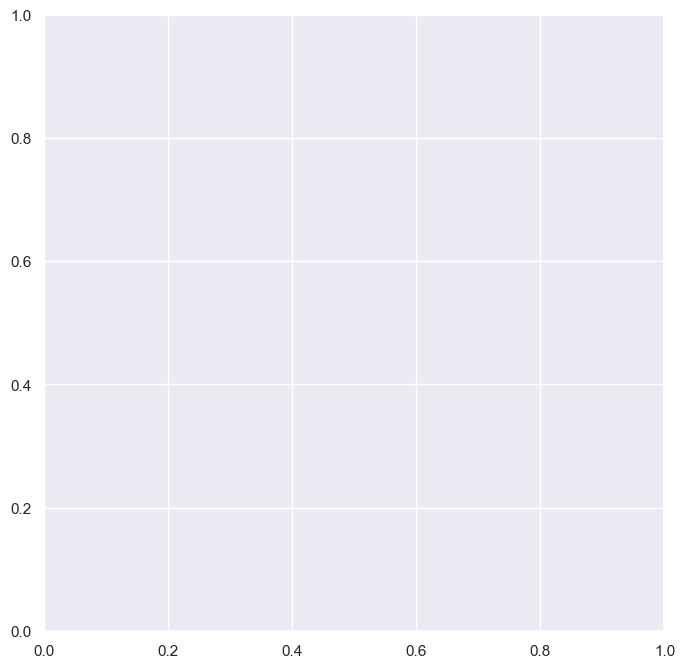

In [362]:
pca = PCA(n_components=5)
train_arr=pca.fit_transform(x_std)

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8))

ax = sns.kdeplot(train_arr[:,0], train_arr[:,1], cmap="Greens",
                shade=True, shade_lowest=False)
ax = sns.kdeplot(train_arr[:,1], train_arr[:,2], cmap="Reds",
                shade=True, shade_lowest=False)
ax = sns.kdeplot(train_arr[:,2], train_arr[:,3], cmap="Blues",
                shade=True, shade_lowest=False)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.5, 0.5, "2nd and 3rd projection", size=12, color=blue)
ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
plt.xlim(-6,5)
plt.ylim(-2,2)

##### Algorithm

In [363]:
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [364]:
train_reg = train.copy()
train_reg.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score
0,female,1,standard,none,62,76,67,68.33
1,male,4,standard,none,79,57,58,64.67
2,female,2,standard,none,77,86,84,82.33
3,female,0,free/reduced,none,45,46,49,46.67
4,male,3,standard,completed,82,83,85,83.33


In [365]:
train = train.drop("mean_score", axis=1)

In [366]:
train.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,1,standard,none,62,76,67
1,male,4,standard,none,79,57,58
2,female,2,standard,none,77,86,84
3,female,0,free/reduced,none,45,46,49
4,male,3,standard,completed,82,83,85


##### OHE

In [367]:
encoder = OneHotEncoder()

In [368]:
encoder_df = pd.DataFrame(encoder.fit_transform(train[["gender", "lunch", "test preparation course"]]).toarray())
encoder_df.columns = ["female", "male", "free/reduced", "standard", "completed", "none"]
train_encoded = train.join(encoder_df)
train_encoded.drop(["gender", "lunch", "test preparation course"], axis=1, inplace=True)
train_encoded.head()

,parental level of education,math score,reading score,writing score,female,male,free/reduced,standard,completed,none
0,1,62,76,67,1.0,0.0,0.0,1.0,0.0,1.0
1,4,79,57,58,0.0,1.0,0.0,1.0,0.0,1.0
2,2,77,86,84,1.0,0.0,0.0,1.0,0.0,1.0
3,0,45,46,49,1.0,0.0,1.0,0.0,0.0,1.0
4,3,82,83,85,0.0,1.0,0.0,1.0,1.0,0.0


In [369]:
encoder_df = pd.DataFrame(encoder.fit_transform(test[["gender", "lunch", "test preparation course"]]).toarray())
encoder_df.columns = ["female", "male", "free/reduced", "standard", "completed", "none"]
test_encoded = test.join(encoder_df)
test_encoded.drop(["gender", "lunch", "test preparation course"], axis=1, inplace=True)
test_encoded.head()

,math score,reading score,writing score,female,male,free/reduced,standard,completed,none
0,54,43,45,0.0,1.0,0.0,1.0,0.0,1.0
1,72,77,77,1.0,0.0,0.0,1.0,0.0,1.0
2,87,97,100,1.0,0.0,0.0,1.0,0.0,1.0
3,55,55,55,0.0,1.0,0.0,1.0,0.0,1.0
4,56,54,43,0.0,1.0,0.0,1.0,0.0,1.0


##### VIF

<!-- ##### Vif formula for OHE
def calculate_vif(data=train_encoded):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# X=df.drop(['Salary'],axis=1)
calculate_vif() -->

In [370]:
pd.DataFrame({"Null values": np.sum(train_encoded.isnull()), "Null percentages":\
              (np.sum(train_encoded.isnull())/len(train)) * 100})

,Null values,Null percentages
parental level of education,0,0.000000
math score,0,0.000000
reading score,0,0.000000
writing score,0,0.000000
female,2,0.250627
male,2,0.250627
free/reduced,2,0.250627
standard,2,0.250627
completed,2,0.250627
none,2,0.250627


<!-- imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(train_encoded)
train_encoded = imputer.transform(train_encoded) -->

In [371]:
# Don't drop just take what's not null
train_encoded = train_encoded[train_encoded["female"].notna()]

In [372]:
train_encoded.head()

,parental level of education,math score,reading score,writing score,female,male,free/reduced,standard,completed,none
0,1,62,76,67,1.0,0.0,0.0,1.0,0.0,1.0
1,4,79,57,58,0.0,1.0,0.0,1.0,0.0,1.0
2,2,77,86,84,1.0,0.0,0.0,1.0,0.0,1.0
3,0,45,46,49,1.0,0.0,1.0,0.0,0.0,1.0
4,3,82,83,85,0.0,1.0,0.0,1.0,1.0,0.0


In [373]:
train_encoded_2 = train_encoded[["parental level of education", "math score", "reading score",
                               "writing score", "female", "free/reduced", "completed"]]

y_3 = train["parental level of education"]
x_3 = train.drop("parental level of education", axis=1)

In [374]:
train_encoded_2.head()

,parental level of education,math score,reading score,writing score,female,free/reduced,completed
0,1,62,76,67,1.0,0.0,0.0
1,4,79,57,58,0.0,0.0,0.0
2,2,77,86,84,1.0,0.0,0.0
3,0,45,46,49,1.0,1.0,0.0
4,3,82,83,85,0.0,0.0,1.0


In [416]:
y = train_encoded_2["parental level of education"]
x = train_encoded_2.drop("parental level of education", axis=1)

y = train_encoded["parental level of education"]
x = train_encoded.drop(["parental level of education"], axis=1)

In [376]:
# Count the disbalance
train.groupby("parental level of education")["parental level of education"].agg("count").values

array([165, 149, 187, 147,  92,  58], dtype=int64)

In [377]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [378]:
y

0       1
1       4
2       2
3       0
4       3
       ..
1117    5
1118    5
1119    5
1120    5
1121    5
Name: parental level of education, Length: 1122, dtype: int64

<AxesSubplot:>

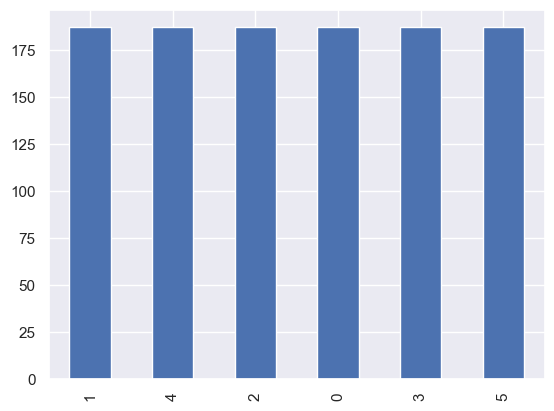

In [379]:
pd.DataFrame(y)["parental level of education"].value_counts().plot.bar()

In [380]:
x["female"] = x["female"].agg(lambda x: int(x))
x["free/reduced"] = x["free/reduced"].agg(lambda x: int(x))
x["completed"] = x["completed"].agg(lambda x: int(x))

In [381]:
x.head()

,math score,reading score,writing score,female,free/reduced,completed
0,62,76,67,1,0,0
1,79,57,58,0,0,0
2,77,86,84,1,0,0
3,45,46,49,1,1,0
4,82,83,85,0,0,1


In [382]:
pd.DataFrame(y).groupby("parental level of education")["parental level of education"].agg("count").values

array([187, 187, 187, 187, 187, 187], dtype=int64)

In [384]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [385]:
x_train.head()

,math score,reading score,writing score,female,free/reduced,completed
206,30,43,40,1,1,0
960,68,71,68,0,1,0
316,77,70,78,0,0,1
147,66,73,68,1,0,0
42,60,76,65,1,0,0


<AxesSubplot:>

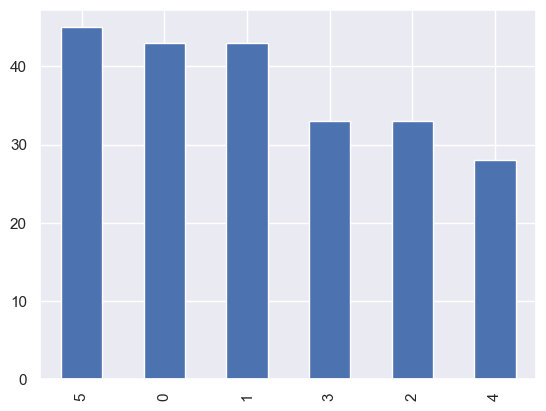

In [389]:
pd.DataFrame(y_val)["parental level of education"].value_counts().plot.bar()

### SVM

In [390]:
clf = SVC(decision_function_shape="ovo", kernel = 'poly', degree= 3, class_weight="balanced")
clf.fit(x_train, y_train)
y_pred=clf.predict(x_val)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model accuracy score with default hyperparameters: 0.2622


In [391]:
clf = SVC(kernel = 'rbf', class_weight="balanced").fit(x_train, y_train)
clf_pred = clf.predict(x_val)
clf_pred

array([3, 0, 0, 0, 3, 3, 1, 0, 1, 1, 4, 1, 3, 1, 4, 0, 4, 3, 1, 4, 3, 4,
       1, 0, 4, 0, 3, 3, 4, 0, 0, 4, 4, 0, 0, 0, 0, 1, 1, 0, 4, 1, 0, 1,
       0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 4, 4, 4,
       4, 0, 4, 4, 4, 1, 0, 1, 4, 3, 3, 4, 1, 0, 1, 3, 4, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 4, 0, 3, 3, 4, 0, 0, 1, 4, 1, 1, 4, 3, 0, 0, 0, 0, 4,
       3, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 4, 3, 4, 0, 0, 4, 4, 4,
       4, 1, 0, 4, 0, 0, 0, 0, 1, 4, 0, 0, 1, 1, 4, 4, 4, 0, 0, 1, 3, 0,
       3, 4, 4, 0, 1, 0, 4, 1, 4, 1, 0, 0, 3, 1, 0, 4, 1, 0, 0, 4, 1, 0,
       4, 0, 0, 0, 3, 0, 4, 4, 4, 0, 4, 1, 3, 0, 0, 3, 1, 4, 1, 0, 4, 0,
       0, 1, 0, 0, 0, 3, 4, 4, 0, 4, 4, 1, 1, 1, 0, 0, 3, 0, 1, 4, 3, 4,
       0, 0, 1, 3, 4], dtype=int64)

In [392]:
clf_accuracy = accuracy_score(y_val, clf_pred)
clf_f1 = f1_score(y_val, clf_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (clf_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (clf_f1*100))

Accuracy (Polynomial Kernel):  21.33
F1 (Polynomial Kernel):  16.48


oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [393]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.fit_transform(x_val)

In [394]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(x_train_scaled, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, class_weight="balanced").fit(x_train_scaled, y_train)

In [395]:
poly_pred = poly.predict(x_val_scaled)
rbf_pred = rbf.predict(x_val_scaled)

In [396]:
poly_accuracy = accuracy_score(y_val, poly_pred)
poly_f1 = f1_score(y_val, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  29.33
F1 (Polynomial Kernel):  25.13


In [397]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
               'class_weight': ['balanced']},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000],
                    'class_weight': ['balanced']}]

In [398]:
pd.DataFrame({"Null values": np.sum(x_train.isnull()), "Null percentages":\
              (np.sum(x_train.isnull())/len(train)) * 100})

,Null values,Null percentages
math score,0,0.0
reading score,0,0.0
writing score,0,0.0
female,0,0.0
free/reduced,0,0.0
completed,0,0.0


In [399]:
%%time
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(x_train_scaled, y_train)

KeyboardInterrupt: 

In [400]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
final_model = svm_model.best_estimator_
y_pred = final_model.predict(x_val_scaled)
# y_pred = y_pred.reshape(1, -1)
y_pred_label = list(encoder.inverse_transform(y_pred))

In [ ]:
print(confusion_matrix(y_val, clf_pred))
print("\n")
print(classification_report(y_val, clf_pred))

print("Training set score for SVM: %f" % final_model.score(x_train, y_train))
print("Testing  set score for SVM: %f" % final_model.score(x_val, y_val))

svm_model.score

In [ ]:
rmse_ridge = np.round(np.sqrt(np.square(np.subtract(y_val, y_pred)).mean()), 3)
print(f"The final error for the ridge_model is: {rmse_ridge}")

In [ ]:
train_error=[rmse_ridge]
col={"Train Error": train_error}
models=['Ridge Regression']
df_rmse=pd.DataFrame(data=col,index=models)
df_rmse

In [ ]:
df_rmse.plot(kind='bar', logy=True, title= "RMSE per model")

##### XGB

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_val)

In [ ]:
print(confusion_matrix(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

print("Training set score for xgboost: %f" % model.score(x_train, y_train))
print("Testing  set score for xgboost: %f" % model.score(x_val, y_val))



In [ ]:
nb = ComplementNB()
nb.fit(x_train, y_train)

In [273]:
pred_nb = nb.predict(x_val)

In [274]:
print(confusion_matrix(y_val, pred_nb))
print("\n")
print(classification_report(y_val, pred_nb))

[[ 8  1 11  1  0  9]
 [ 6  1 12  1  0 17]
 [ 5  2 11  4  2 11]
 [ 8  3  8  1  4 12]
 [ 0  1  9  3  4 26]
 [ 4  1  3  2  0 34]]


              precision    recall  f1-score   support

           0       0.26      0.27      0.26        30
           1       0.11      0.03      0.04        37
           2       0.20      0.31      0.25        35
           3       0.08      0.03      0.04        36
           4       0.40      0.09      0.15        43
           5       0.31      0.77      0.44        44

    accuracy                           0.26       225
   macro avg       0.23      0.25      0.20       225
weighted avg       0.24      0.26      0.20       225



In [275]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_val)

In [276]:
print(confusion_matrix(y_val, rfc_pred))
print("\n")
print(classification_report(y_val, rfc_pred))

[[10  6  5  4  1  4]
 [ 8 13  5  4  4  3]
 [11  4  7  4  5  4]
 [ 2  7  4 11  8  4]
 [ 2  2  3  3 24  9]
 [ 1  0  5  3  4 31]]


              precision    recall  f1-score   support

           0       0.29      0.33      0.31        30
           1       0.41      0.35      0.38        37
           2       0.24      0.20      0.22        35
           3       0.38      0.31      0.34        36
           4       0.52      0.56      0.54        43
           5       0.56      0.70      0.63        44

    accuracy                           0.43       225
   macro avg       0.40      0.41      0.40       225
weighted avg       0.41      0.43      0.42       225



In [277]:
features = train[["math score", "reading score", "writing score"]]
y_ = train["parental level of education"]

##### NN

In [278]:
x_train.head()

,math score,reading score,writing score,female,free/reduced,completed
459,54,61,71,1,0,0
685,77,67,64,1,0,0
245,48,39,40,0,1,0
795,86,77,78,1,0,0
435,35,43,35,1,0,0


In [300]:
epochs = 100
batch_size = 16

In [301]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='tanh', input_dim=6))
model.add(tf.keras.layers.Dense(256, activation='tanh'))
model.add(tf.keras.layers.Dense(512, activation='tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [302]:
model.fit(x_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          steps_per_epoch=x_train.shape[0]//batch_size,)

Epoch 1/100
56/56 [==============================] - 1s 6ms/step - loss: 2.2160 - accuracy: 0.2098
Epoch 2/100
56/56 [==============================] - 0s 7ms/step - loss: 2.0116 - accuracy: 0.1850
Epoch 3/100
56/56 [==============================] - 0s 8ms/step - loss: 1.8910 - accuracy: 0.2179
Epoch 4/100
56/56 [==============================] - 0s 7ms/step - loss: 1.7901 - accuracy: 0.1998
Epoch 5/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7499 - accuracy: 0.2361
Epoch 6/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7683 - accuracy: 0.2043
Epoch 7/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7536 - accuracy: 0.2100
Epoch 8/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7383 - accuracy: 0.2327
Epoch 9/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7564 - accuracy: 0.2202
Epoch 10/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7335 - accuracy: 0.2191
Epoch 11/

56/56 [==============================] - 0s 6ms/step - loss: 1.6979 - accuracy: 0.2826
Epoch 84/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7070 - accuracy: 0.2792
Epoch 85/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7109 - accuracy: 0.2826
Epoch 86/100
56/56 [==============================] - 0s 6ms/step - loss: 1.6945 - accuracy: 0.2826
Epoch 87/100
56/56 [==============================] - 0s 6ms/step - loss: 1.6870 - accuracy: 0.2656
Epoch 88/100
56/56 [==============================] - 0s 6ms/step - loss: 1.6815 - accuracy: 0.2963
Epoch 89/100
56/56 [==============================] - 0s 6ms/step - loss: 1.7132 - accuracy: 0.2588
Epoch 90/100
56/56 [==============================] - 0s 6ms/step - loss: 1.6976 - accuracy: 0.2883
Epoch 91/100
56/56 [==============================] - 0s 6ms/step - loss: 1.6731 - accuracy: 0.3053
Epoch 92/100
56/56 [==============================] - 0s 6ms/step - loss: 1.6991 - accuracy: 0.2928
Epoch 93/100


In [283]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_val)

In [284]:
print(confusion_matrix(y_val, knn_pred))
print("\n")
print(classification_report(y_val, knn_pred))

[[13  5  5  3  1  3]
 [ 9 13  7  3  2  3]
 [10  4  6  5  6  4]
 [ 4  6  5  8  8  5]
 [ 4  2  5  4 20  8]
 [ 4  2  5  5  5 23]]


              precision    recall  f1-score   support

           0       0.30      0.43      0.35        30
           1       0.41      0.35      0.38        37
           2       0.18      0.17      0.18        35
           3       0.29      0.22      0.25        36
           4       0.48      0.47      0.47        43
           5       0.50      0.52      0.51        44

    accuracy                           0.37       225
   macro avg       0.36      0.36      0.36       225
weighted avg       0.37      0.37      0.37       225



In [285]:
train.shape

(798, 7)

In [286]:
y = train_encoded["parental level of education"]
x = train_encoded.drop(["parental level of education"], axis=1)

In [321]:
kfold = model_selection.KFold(n_splits=10) 
# create the sub models
estimators = [] 
model1 = LogisticRegression() 
estimators.append(('logistic', model1)) 
model2 = DecisionTreeClassifier() 
estimators.append(('cart', model2)) 
model3 = SVC()
estimators.append(('svm', model3)) 
# create the ensemble model 
ensemble=VotingClassifier(estimators) 
results = model_selection.cross_val_score(ensemble, x, y, cv=kfold)
print(results.mean())

0.24104430379746833


#####  Stratified Kfold

In [556]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
# from imblearn.pipeline import make_pipeline

In [557]:
train_encoded_2["female"] = train_encoded_2["female"].agg(lambda x: int(x))
train_encoded_2["free/reduced"] = train_encoded_2["free/reduced"].agg(lambda x: int(x))
train_encoded_2["completed"] = train_encoded_2["completed"].agg(lambda x: int(x))

In [562]:
y = train_encoded_2["parental level of education"]
x = train_encoded_2.drop("parental level of education", axis=1)
y = LabelEncoder().fit_transform(y)

<!-- y = LabelEncoder().fit_transform(y)
# transform the dataset
strategy = {0:100, 1:100, 2:200, 3:200, 4:200, 5:200}
oversample = SMOTE(sampling_strategy="all")
x, y = oversample.fit_resample(x, y) -->

In [573]:
from sklearn.utils import class_weight
classes_weights = list(class_weight.compute_class_weight('balanced',
                                             classes=np.unique(y),
                                             y=y))

weights = np.ones(y.shape[0], dtype = 'float')
for i, val in enumerate(y):
    weights[i] = classes_weights[val-1]

In [574]:
steps = [('scaler', RobustScaler()), ('over', SMOTE()), 
         ('model', XGBClassifier(sample_weight=weights))]
pipeline = Pipeline(steps=steps)
# pipeline = make_pipeline[('over', SMOTE()), ('model', LogisticRegression())]

In [560]:
train_encoded.head()

,parental level of education,math score,reading score,writing score,female,male,free/reduced,standard,completed,none
0,1,62,76,67,1.0,0.0,0.0,1.0,0.0,1.0
1,4,79,57,58,0.0,1.0,0.0,1.0,0.0,1.0
2,2,77,86,84,1.0,0.0,0.0,1.0,0.0,1.0
3,0,45,46,49,1.0,0.0,1.0,0.0,0.0,1.0
4,3,82,83,85,0.0,1.0,0.0,1.0,1.0,0.0


<AxesSubplot:xlabel='0'>

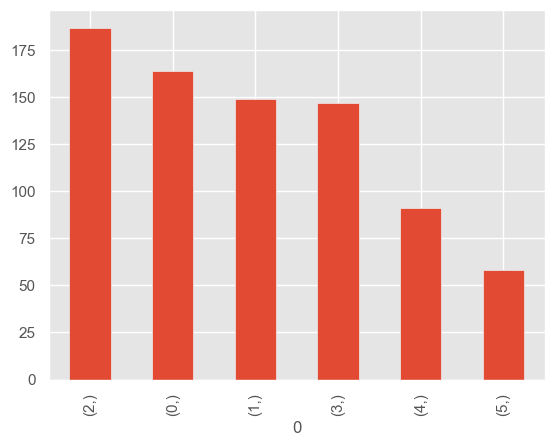

In [570]:
pd.DataFrame(y).value_counts().plot.bar()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [571]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
scores = cross_val_score(pipeline, x, y, scoring="f1_macro", cv=cv)
print("Model F1-Score",  " mean=", scores.mean() , "stddev=", scores.std())
print(scores)

[16:18:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  

[16:18:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  

[16:18:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  

[16:18:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  

[16:18:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:18:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  

Model F1-Score  mean= 0.1645090135669792 stddev= 0.04301312096516669
[0.17123376 0.12259325 0.11100179 0.09408182 0.14500425 0.18566544
 0.10285205 0.19162676 0.17407173 0.14778408 0.13253129 0.17290009
 0.31084547 0.1156903  0.10166318 0.10093156 0.24435564 0.14810106
 0.15835977 0.18772986 0.13537632 0.1463135  0.16758832 0.12998503
 0.18285298 0.22097701 0.1522693  0.14087995 0.1752442  0.180891
 0.15002036 0.14737654 0.2134371  0.24389321 0.17321799 0.14280397
 0.20273055 0.19316472 0.13243388 0.18417556 0.15578704 0.14685143
 0.08052397 0.13469293 0.17632318 0.06984127 0.22096333 0.224682
 0.2027269  0.17146264 0.11706127 0.08909316 0.17207834 0.18234308
 0.16261427 0.13617681 0.19052785 0.21675021 0.19732787 0.16722913
 0.17693399 0.15477652 0.12303431 0.21235834 0.15538557 0.09516302
 0.11545812 0.14487656 0.16673237 0.15151056 0.0968414  0.20065866
 0.26396888 0.22867569 0.11884412 0.18672639 0.22575224 0.21230223
 0.11052632 0.10536268 0.18893557 0.16111111 0.18353065 0.163283

In [452]:
train.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,1,standard,none,62,76,67
1,male,4,standard,none,79,57,58
2,female,2,standard,none,77,86,84
3,female,0,free/reduced,none,45,46,49
4,male,3,standard,completed,82,83,85
